In [2]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import io
import torch
import numpy as np
from CONFIG import config
from datalib import build_data_loader, load_data
from utils.utils import count_model_params, load_model
from utils.visualization import plot_images_vs_recons
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = config['data']['dataset_path']
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### - ***Data Visualization***

* Here, we investigate the transforms on train dataset. We compare the data in a sequence before and after the transformations being applied. 

* The transforms are implemented to equally to all the samples in a sequence, preserving the time consistanct of the video sequence.

* Each new sequence gets fresh random decisions for augmentation. This is done in MoviC.py file line 49 (self.transforms.reset_sequence(sequence_idx=idx), num_epochs=self.num_epochs) resets the flags for horizontal and vertical flips.

* For the sake of having the same transformation on all data in a sequence, we needed to have different seeds per sequence. But at the same time we need a base/stable seed during training the model and initializeing the tensors. To solve this problem, we considered the seed for training as `base_seed` which is increased by idx - the index of the sequence in the dataset - and also a random value in range(epoch). This ensures both consistancy during data augmentatin per sequence, diversity per sequence/epoch, and also during training procecss for tensors (having a defined base-seed).( This is done in _make_sequence_decisions() function line 41 in utils.transforms.py). Although this approach provides `deterministicc` results for agumentation `per_sequence`, is it `non-deterministic` `per run`!

* For each sequence, the choosen augmentation can be aither vertical, horizontal, both, or neither! This is also done in _make_sequence_decisions() function in MoviC.py. We consider independent probabilities for each augmentation:

    - should_hflip = random.random() < 0.3: 30% chance of horizontal flip.
    - should_vflip = random.random() < 0.7: 70% chance of vertical flip.

    Since these are independent, the possible outcomes per sequence are:

    - Neither: (1-0.3) * (1-0.7) = 70% * 30% = 21% probability.

    - Horizontal only: 30% * 30% = 9% probability.

    - Vertical only: 70% * 70% = 49% probability.

    - Both: 30% * 70% = 21% probability.

    

In [ ]:

# Apply transforms to ENTIRE sequence using transform pipeline

train_dataset = load_data(path, split='train', use_transforms=False, Visualize=True)
train_dataset_transformed = load_data(path, split='train', use_transforms=True, Visualize=True)


[INFO] - TRAIN Data Loaded: Coordinates: 9737, Masks: 9737, RGB videos:  9737, Flows:  9737
[INFO] - TRAIN Data Loaded: Coordinates: 9737, Masks: 9737, RGB videos:  9737, Flows:  9737


**First run: only vertical flip**

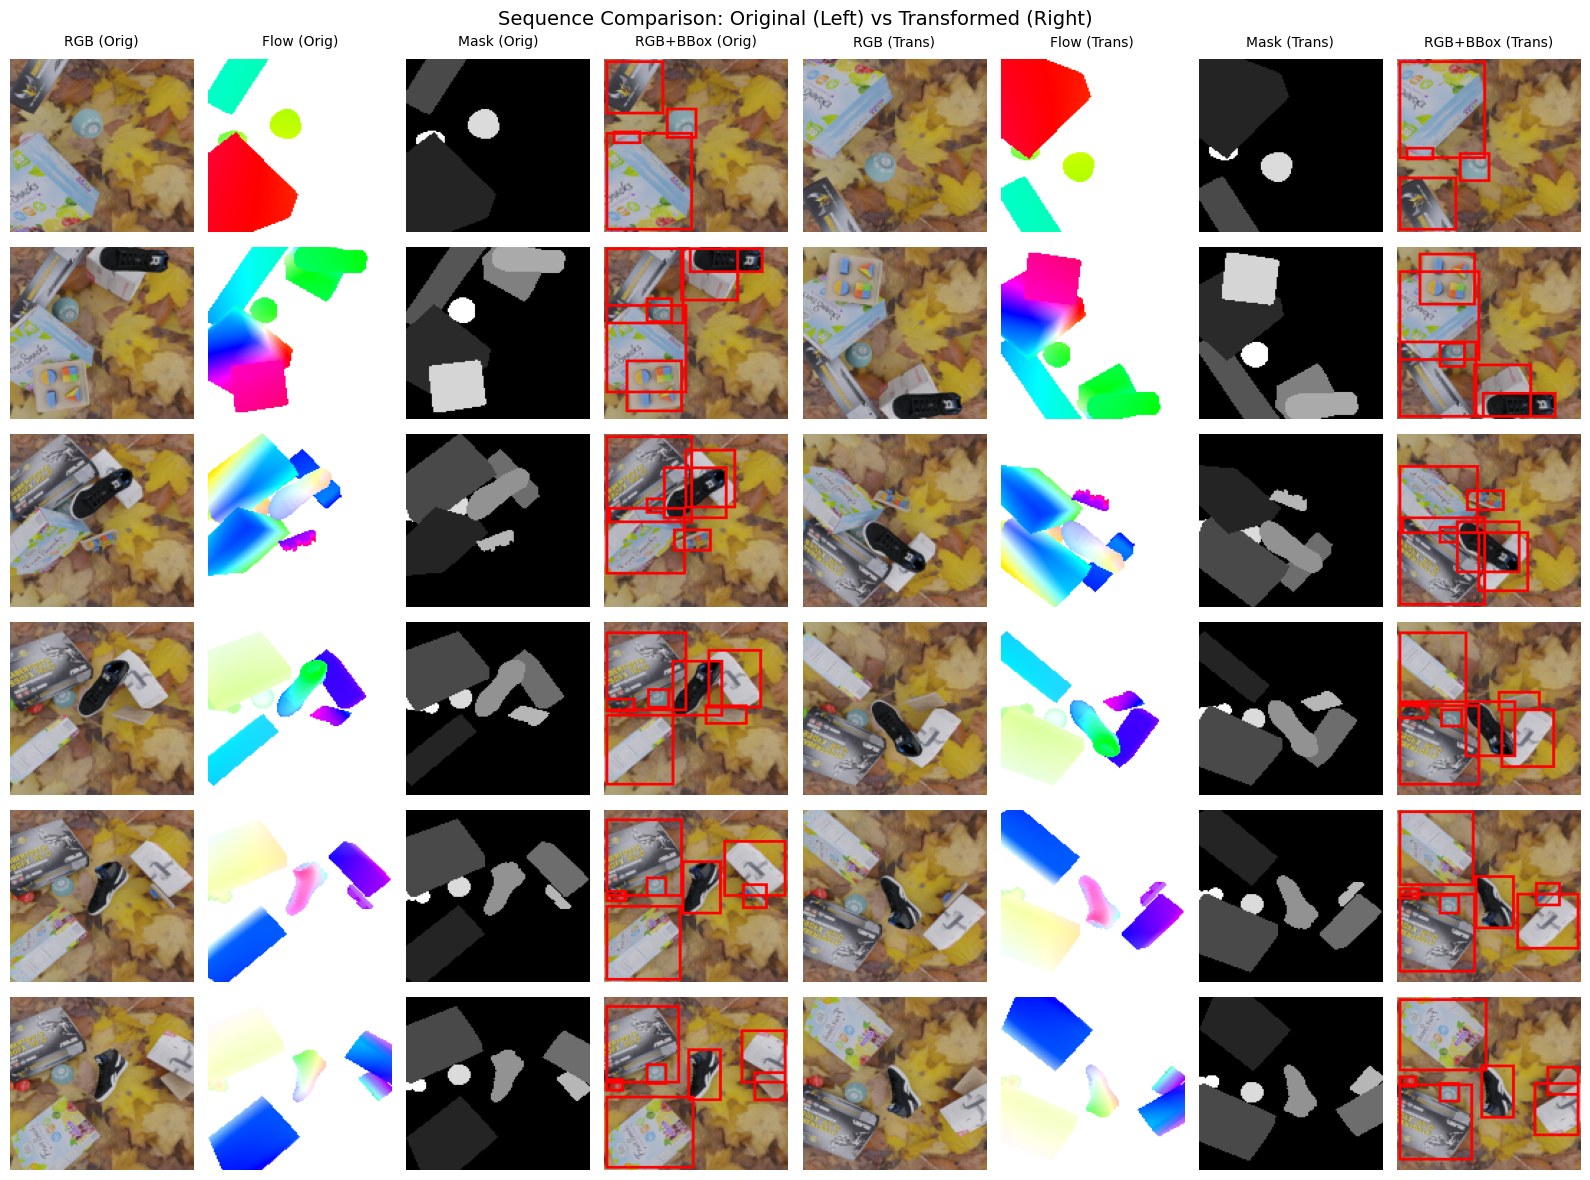

In [66]:
from utils.visualization import plot_transform_comparison


idx = np.random.randint(0, len(train_dataset))

rgbs_orig, masks_orig, flows_orig, coords_orig = train_dataset[idx]
rgbs_trans, masks_trans, flows_trans, coords_trans = train_dataset_transformed[idx]


plot_transform_comparison(
                        rgbs_orig, masks_orig, flows_orig, coords_orig,
                        rgbs_trans, masks_trans, flows_trans, coords_trans,
                        n_rows=6, sequence_idx=idx
                        )

**Second run: Both horizontal and vertical flips**

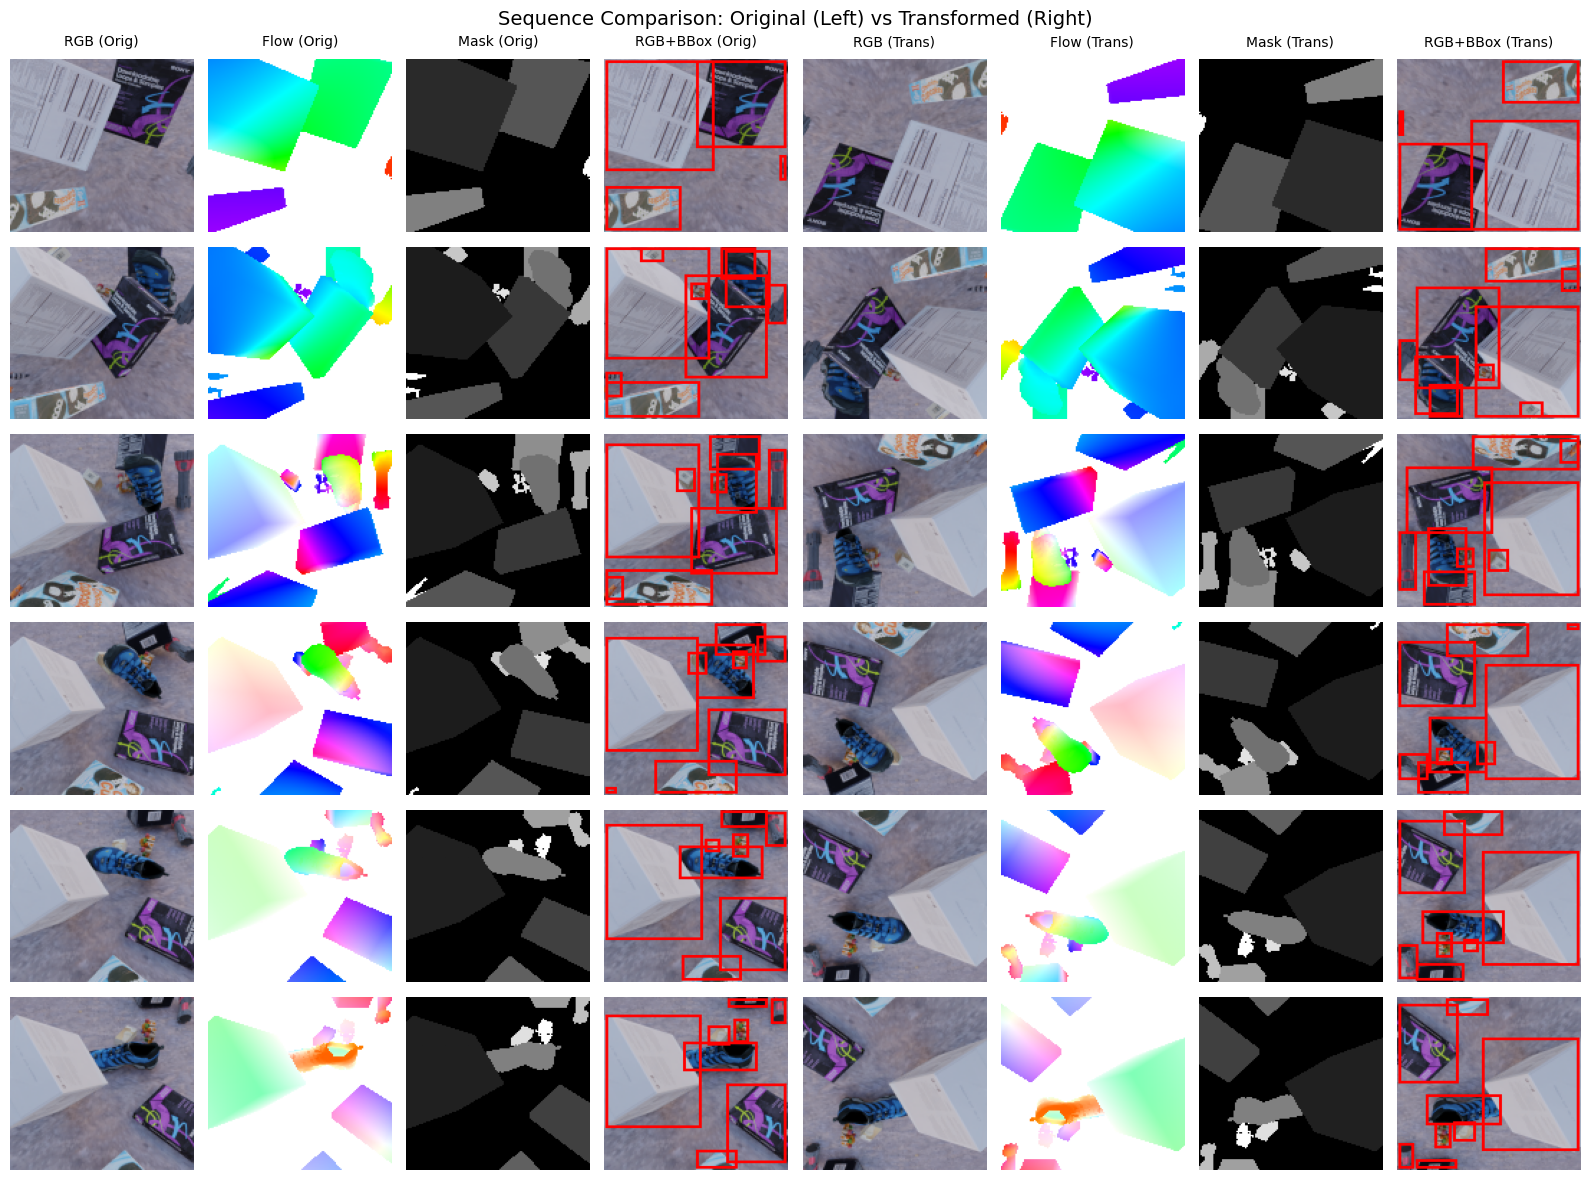

In [90]:
idx = np.random.randint(0, len(train_dataset))

rgbs_orig, masks_orig, flows_orig, coords_orig = train_dataset[idx]
rgbs_trans, masks_trans, flows_trans, coords_trans = train_dataset_transformed[idx]


plot_transform_comparison(
                        rgbs_orig, masks_orig, flows_orig, coords_orig,
                        rgbs_trans, masks_trans, flows_trans, coords_trans,
                        n_rows=6, sequence_idx=idx
                        )

### - ***Datalloaders and modality shapes***

In [3]:
val_dataset = load_data(path, split='validation', use_transforms=True)

# train_loader= build_data_loader(train_dataset, split='train')
val_loader = build_data_loader(val_dataset, split='validation')


[INFO] - VALIDATION Data Loaded: Coordinates: 250, Masks: 250, RGB videos:  250, Flows:  250


In [4]:
## Verifying the dataloader  
rgbs, masks, flows, coords = next(iter(val_loader))

# Send all tensors to device
rgbs = rgbs.to(device)
flows = flows.to(device)

# Move all mask tensors to device
for k in masks:
    masks[k] = masks[k].to(device)

# Move all coords tensors to device
for k in coords:
    coords[k] = coords[k].to(device)

print(f"RGBs shape: {rgbs.shape}\nFlows shape: {flows.shape}\nMasks shape: {masks['masks'].shape} \nCoords com shape: {coords['com'].shape}\nCoords bbxs shape: {coords['bbox'].shape}")


RGBs shape: torch.Size([8, 24, 3, 64, 64])
Flows shape: torch.Size([8, 24, 3, 64, 64])
Masks shape: torch.Size([8, 24, 64, 64]) 
Coords com shape: torch.Size([8, 24, 11, 2])
Coords bbxs shape: torch.Size([8, 24, 11, 4])


### - ***Utility visualization***

Here, we will visulize some of the helper fucntions used during training

1. During object-centric scene representation learning, each token is an object image. Therefore ,we need to extract object images from frames. We can achieve this goal using either bboxs or mask labels. First we will exploer extracting object frames from masks: 

In [113]:
'''
Used during training the object-centric model. when masks labels are used to extract object frames from one image. 
The object frames are then used to guide the prediction of the next frame.
'''

def extract_object_specific_frames_from_masks(images, masks, num_objects):
    """
    images: Tensor of shape [B, T, C, H, W]
    masks: Tensor of shape [B, T, H, W] with int values from 0 to num_objects-1
    num_objects: int, number of unique objects (including background if needed)

    Returns:
        object_frames: Tensor of shape [B, T, num_objects, C, H, W]
    """
    B, T, C, H, W = images.shape
    device = images.device

    # Expand images for each object
    object_frames = torch.zeros(B, T, num_objects, C, H, W, device=device, dtype=images.dtype)

    for obj_id in range(num_objects):
        # Create mask for this object: shape [B, T, 1, H, W]
        obj_mask = (masks == obj_id).unsqueeze(2)  # [B, T, 1, H, W]
        # Broadcast mask to all channels
        obj_mask = obj_mask.expand(-1, -1, C, -1, -1)  # [B, T, C, H, W]
        # Apply mask
        object_frames[:, :, obj_id] = images * obj_mask

    return object_frames

num_objects = 11
object_frames = extract_object_specific_frames_from_masks(rgbs, masks['masks'], num_objects)
object_frames.shape

torch.Size([8, 24, 11, 3, 128, 128])

- As we can see, we extracted 11 (one background + 10 objects in Movi-C dataset) different "`object_frames`" from one image. No we visualize them:

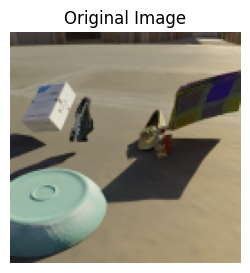

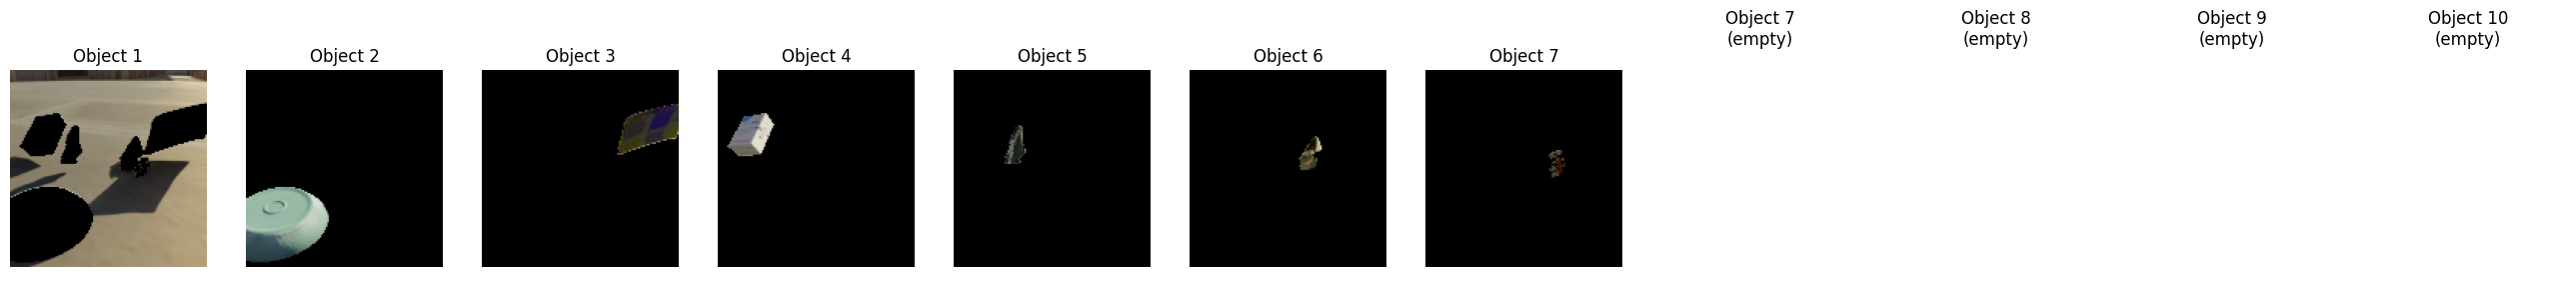

In [116]:
from utils.visualization import plot_object_frames

# Choose the first batch and time step
batch_idx = 3
seq_idx = 11

# object_frames shape: [B, T, num_objects, C, H, W]
# We'll print all object frames for this batch and time step
num_objects = len(object_frames[batch_idx][seq_idx])

plot_object_frames(rgbs, object_frames, batch_idx, seq_idx)

2. Now we investigate extracting object frames from bounding boxes:

In [ ]:

def extract_object_specific_frames_from_bboxes(images, bboxes):
    """
    images: Tensor of shape [B, T, C, H, W]
    bboxes: Tensor of shape [B, T, num_objects, 4] (x1, y1, x2, y2) in pixel coordinates

    Returns:
        object_frames: Tensor of shape [B, T, num_objects, C, H, W]
    """
    B, T, C, H, W = images.shape
    device = images.device
    num_objects = bboxes.shape[2]

    # Prepare output tensor
    object_frames = torch.zeros(B, T, num_objects, C, H, W, device=device, dtype=images.dtype)

    for obj_id in range(num_objects):
        for b in range(B):
            for t in range(T):
                x1, y1, x2, y2 = bboxes[b, t, obj_id]
                # Clamp coordinates to image bounds and convert to int
                x1 = int(torch.clamp(x1, 0, W-1).item())
                y1 = int(torch.clamp(y1, 0, H-1).item())
                x2 = int(torch.clamp(x2, 0, W-1).item())
                y2 = int(torch.clamp(y2, 0, H-1).item())
                # Ensure valid bbox
                if x2 > x1 and y2 > y1:
                    # Copy the region from the image to the corresponding location in object_frames
                    object_frames[b, t, obj_id, :, y1:y2, x1:x2] = images[b, t, :, y1:y2, x1:x2]
                # else: leave as zeros (background)
    return object_frames

object_frames = extract_object_specific_frames_from_bboxes(rgbs, coords['bbox'])
object_frames.shape


torch.Size([8, 24, 11, 3, 128, 128])

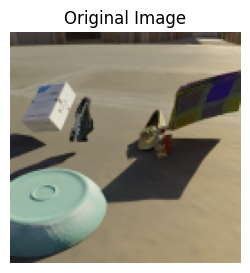

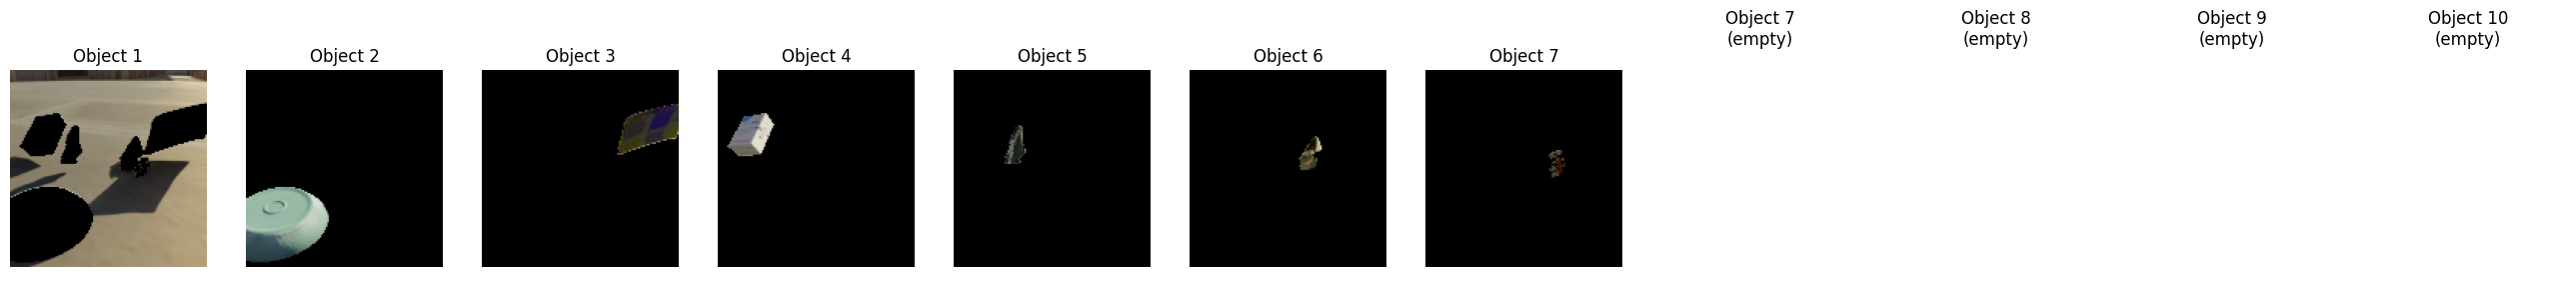

In [117]:

plot_object_frames(rgbs, object_frames, batch_idx, seq_idx)


### Patchifier
Another utility function to patchify input images. Only used in the `Holistic scene representation training` where each patch is considered as a token.

Patchified Shape: torch.Size([32, 24, 64, 768])
Number of patches: 64
Patch size: 16


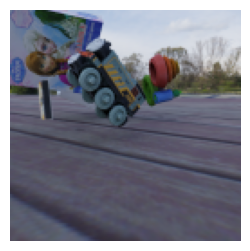

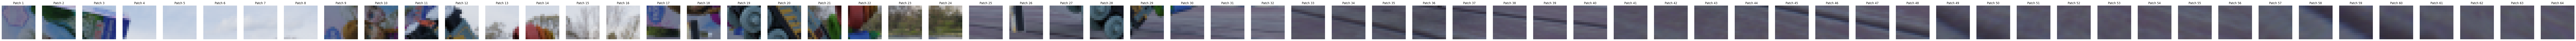

In [10]:
from model.model_utils import Patchifier

BATCH_IDX = 4
seq_len = 5
img = rgbs[BATCH_IDX, seq_len]

plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

patch_size = config['data']['patch_size'] # num of H and W pixels of each patch
patchifier = Patchifier(patch_size)
patch_data = patchifier(rgbs)
print(f"Patchified Shape: {patch_data.shape}") # (B, seq_len, num_patch_H * num_patch_W, 3 * 32 * 32)

num_patches = patch_data.shape[2] # num_patches = num_patch_H * num_patch_W
print(f"Number of patches: {num_patches}")
print(f"Patch size: {patch_size}")
fig, ax = plt.subplots(1, num_patches)
fig.set_size_inches(3 * num_patches, 3)
for i in range(num_patches):
    cur_patch = patch_data[BATCH_IDX, seq_len, i].reshape(3, patch_size, patch_size)
    ax[i].imshow(cur_patch.permute(1, 2, 0).cpu().numpy())
    ax[i].set_title(f"Patch {i+1}")
    ax[i].axis("off")

plt.show()

## ***1. Holistic scene representation***

### -  **Holistic Transformer-AutoEncoder Module**

In [6]:
from model.holistic_encoder import HolisticEncoder
from model.holistic_decoder import HolisticDecoder
from model.ocvp import TransformerAutoEncoder


 
<div style="display: flex; gap: 10px;">

<div style="flex: 1;">
  
| **Parameter**           | **Value**         |
|:----------------------- |:----------------:|
| batch_size              | 32               |
| patch_size              | 16               |
| num_workers             | 8                |
| num_epochs              | 100              |
| warmup_epochs           | 5                |
| early_stopping_patience | 10               |
| model_name              | 02_Holistic_AE_XL|
| lr                      | 0.001            |
| encoder_embed_dim       | 512              |
| decoder_embed_dim       | 384              |
| max_len                 | 64               |
| in_out_channels         | 3                |
| attn_dim                | 128              |
| num_heads               | 8                |
| mlp_size                | 1024             |
| encoder_depth           | 12               |
| decoder_depth           | 8                |
| predictor_depth         | 8                |
| predictor_embed_dim     | 256              |
| residual                | true             |

</div>

<div style="flex: 1;">

| **Parameter**           | **Value**         |
|:----------------------- |:----------------:|
| batch_size              | 32               |
| patch_size              | 16               |
| num_workers             | 8                |
| num_epochs              | 100              |
| warmup_epochs           | 5                |
| early_stopping_patience | 10               |
| model_name              | 02_Holistic_AE_XL|
| lr                      | 0.001            |
| encoder_embed_dim       | 512              |
| decoder_embed_dim       | 384              |
| max_len                 | 64               |
| in_out_channels         | 3                |
| attn_dim                | 128              |
| num_heads               | 8                |
| mlp_size                | 1024             |
| encoder_depth           | 12               |
| decoder_depth           | 8                |
| predictor_depth         | 8                |
| predictor_embed_dim     | 256              |
| residual                | true             |

</div>
</div>


* We used `Full-Transformer based Autoencoder` for the Holistic scene scenario. Each image was patfchified into tokens, added positional embeddings, went through transoformer blocks, and normalized to get the desired embeddigns. During the training process, we experienced different transformer architectures, along with input image sizes (64\*64)- right table with moderate parameters,called base- and (128\*128) - left table with larget transformer parameters called XL. The configs were as following: 




<div style="display: flex; gap: 20px; justify-content: center;">

<div style="flex: 1; text-align: center;">

**Large model configs and learning process**

<table align="center">
  <tr><th>Parameter</th><th>Value</th></tr>
  <tr><td>model_name</td><td>02_Holistic_AE_XL</td></tr>
  <tr><td>batch_size</td><td>32</td></tr>
  <tr><td>patch_size</td><td>16</td></tr>
  <tr><td>num_workers</td><td>8</td></tr>
  <tr><td>num_epochs</td><td>100</td></tr>
  <tr><td>warmup_epochs</td><td>5</td></tr>
  <tr><td>early_stopping_patience</td><td>10</td></tr>
  <tr><td>lr</td><td>0.001</td></tr>
  <tr><td>encoder_embed_dim</td><td>512</td></tr>
  <tr><td>decoder_embed_dim</td><td>384</td></tr>
  <tr><td>max_len</td><td>64</td></tr>
  <tr><td>in_out_channels</td><td>3</td></tr>
  <tr><td>attn_dim</td><td>128</td></tr>
  <tr><td>num_heads</td><td>8</td></tr>
  <tr><td>mlp_size</td><td>1024</td></tr>
  <tr><td>encoder_depth</td><td>12</td></tr>
  <tr><td>decoder_depth</td><td>8</td></tr>
  <tr><td>predictor_depth</td><td>8</td></tr>
  <tr><td>predictor_embed_dim</td><td>256</td></tr>
  <tr><td>residual</td><td>true</td></tr>
</table>

</div>

<div style="flex: 1; text-align: center;">

**Based model configs and learning process**

<table align="center">
  <tr><th>Parameter</th><th>Value</th></tr>
  <tr><td>model_name</td><td>01_Holistic_AE_Base</td></tr>
  <tr><td>batch_size</td><td>32</td></tr>
  <tr><td>patch_size</td><td>16</td></tr>
  <tr><td>num_workers</td><td>8</td></tr>
  <tr><td>num_epochs</td><td>100</td></tr>
  <tr><td>warmup_epochs</td><td>5</td></tr>
  <tr><td>early_stopping_patience</td><td>10</td></tr>
  <tr><td>lr</td><td>0.0002</td></tr>
  <tr><td>encoder_embed_dim</td><td>128</td></tr>
  <tr><td>decoder_embed_dim</td><td>64</td></tr>
  <tr><td>max_len</td><td>64</td></tr>
  <tr><td>in_out_channels</td><td>3</td></tr>
  <tr><td>attn_dim</td><td>64</td></tr>
  <tr><td>num_heads</td><td>8</td></tr>
  <tr><td>mlp_size</td><td>512</td></tr>
  <tr><td>encoder_depth</td><td>6</td></tr>
  <tr><td>decoder_depth</td><td>3</td></tr>
  <tr><td>predictor_depth</td><td>4</td></tr>
  <tr><td>predictor_embed_dim</td><td>128</td></tr>
  <tr><td>residual</td><td>true</td></tr>
</table>

</div>
</div>


<p align="center">
  <img src="experiments/images/recons-M.gif" alt="Image 1" width="40%">
  <img src="experiments/images/recons-XL.gif" alt="Image 2" width="40%">
</p>


#### Loss curves for different experimments:

<p align="center">
  <img src="experiments/images/Screenshot from 2025-09-30 18-20-17.png" alt="Image 1" width="40%">
  <img src="experiments/images/Screenshot from 2025-09-30 18-20-39.png" alt="Image 2" width="40%">
</p>


**Note**: 

our base model also could learn proparly with far less parameters, but in the end the quality of recons with the XL model were better and sharper. So we proceded with this model for predictor training

In [11]:

holistic_encoder = HolisticEncoder()

holistic_decoder = HolisticDecoder()
model = TransformerAutoEncoder(holistic_encoder, holistic_decoder).to(device)

summary(model, input_size= rgbs.shape)

Layer (type:depth-idx)                             Output Shape              Param #
TransformerAutoEncoder                             [8, 24, 3, 64, 64]        --
├─HolisticEncoder: 1-1                             [8, 24, 16, 512]          --
│    └─Sequential: 2-1                             [8, 24, 16, 512]          --
│    │    └─LayerNorm: 3-1                         [8, 24, 16, 768]          1,536
│    │    └─Linear: 3-2                            [8, 24, 16, 512]          393,728
│    └─PositionalEncoding: 2-2                     [8, 24, 16, 512]          --
│    └─Sequential: 2-3                             [8, 24, 16, 512]          --
│    │    └─TransformerBlock: 3-3                  [8, 24, 16, 512]          1,314,304
│    │    └─TransformerBlock: 3-4                  [8, 24, 16, 512]          1,314,304
│    │    └─TransformerBlock: 3-5                  [8, 24, 16, 512]          1,314,304
│    │    └─TransformerBlock: 3-6                  [8, 24, 16, 512]          1,314,304

In [8]:
# Full forward pass through the model

with torch.no_grad():
    encoded_features = holistic_encoder(rgbs)
    print("Encoded Features shape:", encoded_features.shape)
    recons, loss = holistic_decoder(encoded_features)
    print("Reconstructed image shape:", recons.shape)
print(f"Reconstructed images match the original images shape: {recons.shape == rgbs.shape}")

Encoded Features shape: torch.Size([8, 24, 16, 512])
Reconstructed image shape: torch.Size([8, 24, 3, 64, 64])
Reconstructed images match the original images shape: True


#### - **Loading Holisitc-AE model pre-trained checkpoints**

In [12]:
path_AE = 'experiments/02_Holistic_AE_XL/checkpoints/best_02_Holistic_AE_XL.pth'
model = load_model(model, mode='AE_inference', path_AE = path_AE)


Now we will evaluate the ability of our pre-trained autoencoder by running a full-forward pass through network using eval iamges and visualize the results.

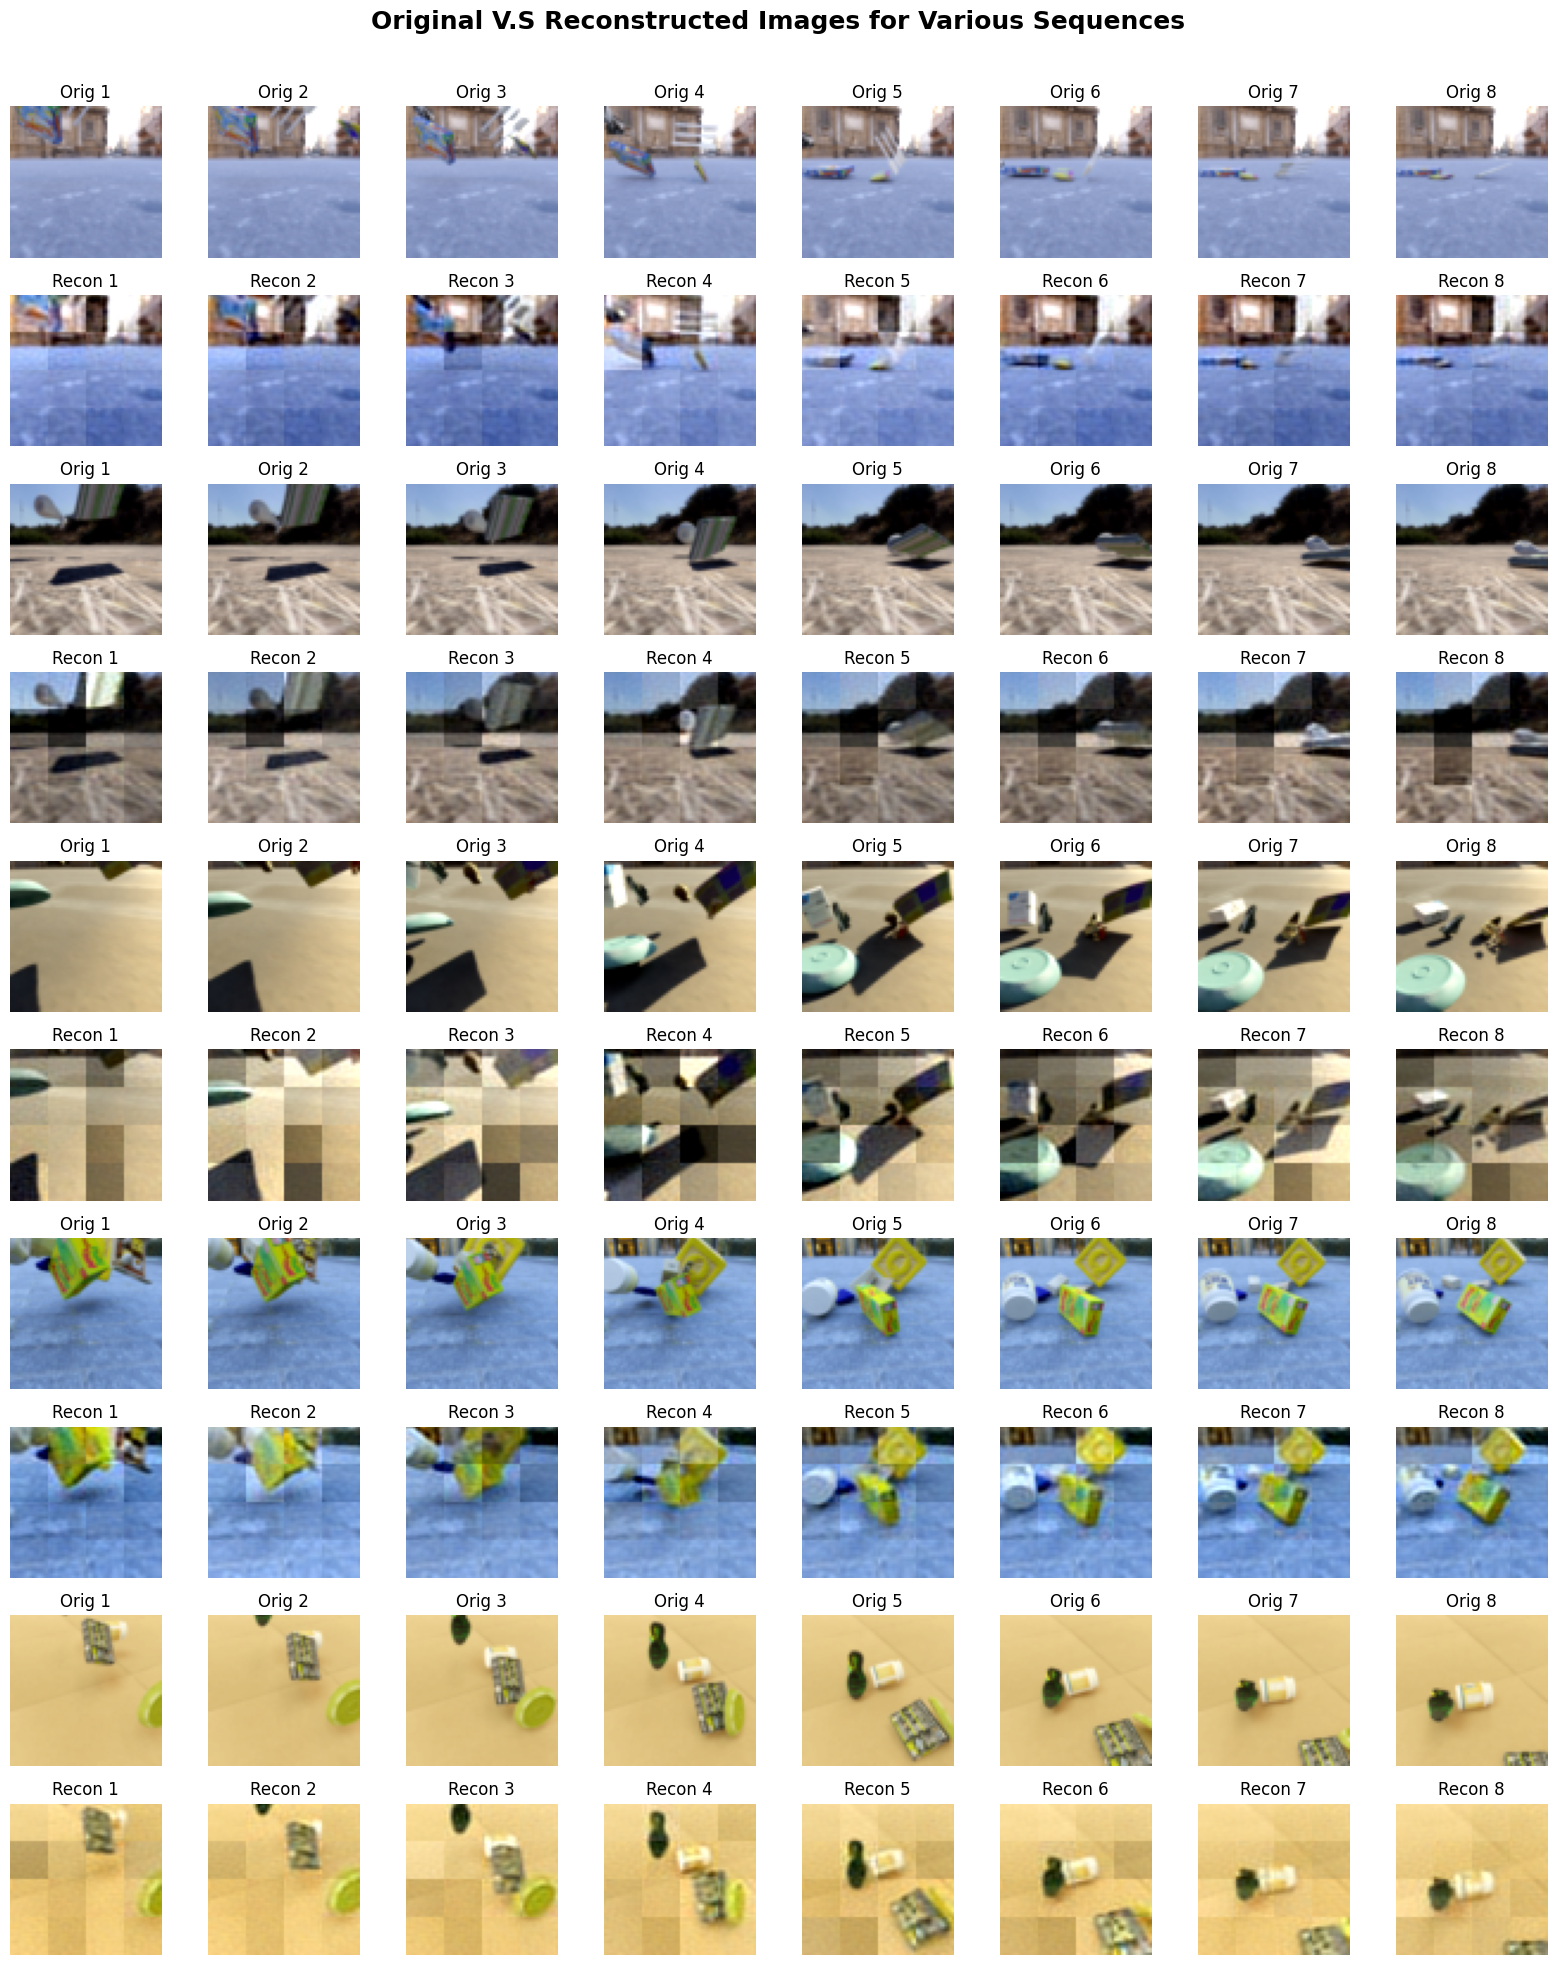

In [13]:

# Generate reconstructions
with torch.no_grad():
    recons, _ = model(rgbs)

# Plot 5 random sequences, each showing 8 original vs 8 reconstructed frames
plot_images_vs_recons(rgbs, recons)


* NOTE :

 As we can see, our autoencoder has efficciently learnt the latent space of the input images and can reconstruct/map any embedding in the given latent space to it's relevant input image. Now let's see how well our Holistic-Predictor can predict the next frames, given no information about the objects.

### - **Holositic Transformer-Predictor Module**

In [11]:
from model.holistic_predictor import HolisticTransformerPredictor
from model.predictor_wrapper import PredictorWrapper
from model.ocvp import TransformerPredictor

In [127]:
holistic_predictor = HolisticTransformerPredictor()
holistic_predictor= PredictorWrapper(holistic_predictor)
model = TransformerPredictor(holistic_encoder, holistic_decoder, holistic_predictor, mode='inference').to(device)

summary(model, input_size= rgbs.shape)


Layer (type:depth-idx)                                  Output Shape              Param #
TransformerPredictor                                    [32, 5, 64, 512]          8,381,312
├─HolisticEncoder: 1-1                                  [32, 24, 64, 512]         --
│    └─Sequential: 2-1                                  [32, 24, 64, 512]         --
│    │    └─LayerNorm: 3-1                              [32, 24, 64, 768]         1,536
│    │    └─Linear: 3-2                                 [32, 24, 64, 512]         393,728
│    └─PositionalEncoding: 2-2                          [32, 24, 64, 512]         --
│    └─Sequential: 2-3                                  [32, 24, 64, 512]         --
│    │    └─TransformerBlock: 3-3                       [32, 24, 64, 512]         1,314,304
│    │    └─TransformerBlock: 3-4                       [32, 24, 64, 512]         1,314,304
│    │    └─TransformerBlock: 3-5                       [32, 24, 64, 512]         1,314,304
│    │    └─TransformerB

In [111]:
def plot_predictor_images(input_images, target_images, recons):
    
    # Plot input images
    fig, axes = plt.subplots(1, input_images.shape[1], figsize=(input_images.shape[1]*3, 3))
    for i in range(input_images.shape[1]):
        ax = axes[i] if input_images.shape[1] > 1 else axes
        img = input_images[0, i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Input {i+1}")
        ax.axis('off')
    plt.suptitle("Input Images")
    plt.show()

    # Plot target images
    fig, axes = plt.subplots(1, target_images.shape[1], figsize=(target_images.shape[1]*3, 3))
    for i in range(target_images.shape[1]):
        ax = axes[i] if target_images.shape[1] > 1 else axes
        img = target_images[0, i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Target {i+1}")
        ax.axis('off')
    plt.suptitle("Target Images")
    plt.show()

    # Plot the reconstructed images from the holistic predictor
    def quantile_0_1(img):
        # img: numpy array, shape [H, W, C] or [C, H, W]
        q_min = np.quantile(img, 0.0)
        q_max = np.quantile(img, 1.0)
        if q_max > q_min:
            img = (img - q_min) / (q_max - q_min)
        else:
            img = np.zeros_like(img)
        img = np.clip(img, 0, 1)
        return img

    if recons.ndim == 5:
        fig, axes = plt.subplots(1, recons.shape[1], figsize=(recons.shape[1]*3, 3))
        for i in range(recons.shape[1]):
            ax = axes[i] if recons.shape[1] > 1 else axes
            img = recons[0, i].detach().cpu().permute(1, 2, 0).numpy()
            img = quantile_0_1(img)
            ax.imshow(img)
            ax.set_title(f"Recon {i+1}")
            ax.axis('off')
        plt.suptitle("Reconstructed Images")
        plt.show()
    else:
        print("Reconstructed output is not in image format and cannot be plotted directly.")


#### ***Loading model pre-trained Holistic-Predictor checkpoints***

In [125]:

path_predictor = '/home/user/soltania1/CourseProject_2/src/experiments/best_03_Holistic_Predictor_XL.pth'

model = load_model(model, mode='inference', path_AE = path_AE, path_predictor=path_predictor)


In [126]:
with torch.no_grad():
    for i in range(rgbs.shape[0]):
        encoded_features = holistic_encoder(rgbs)
        print(encoded_features.shape)
        preds, loss, input_range, target_range = model(rgbs[i].unsqueeze(0))
        print(preds.shape)

        recons, _ = model.decoder(preds)
        print(recons.shape)
        input_images = rgbs[i,input_range[0]:input_range[1]].unsqueeze(0)
        target_images = rgbs[i,target_range[0]:target_range[1]].unsqueeze(0)
        plot_predictor_images(input_images, target_images, recons)
        

torch.Size([32, 24, 64, 512])


AttributeError: 'TransformerPredictor' object has no attribute 'mode'

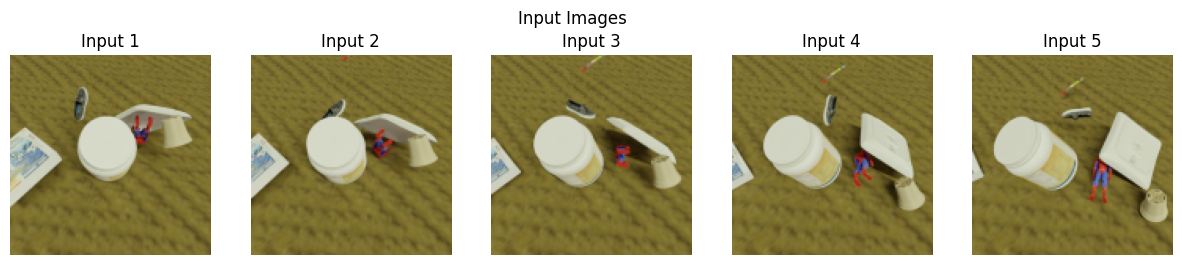

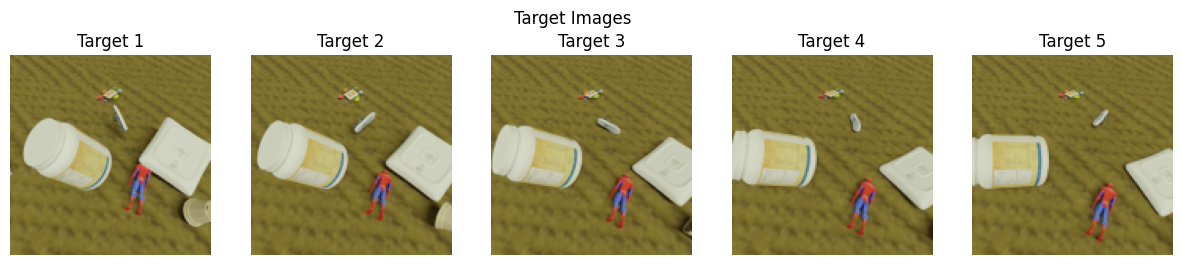

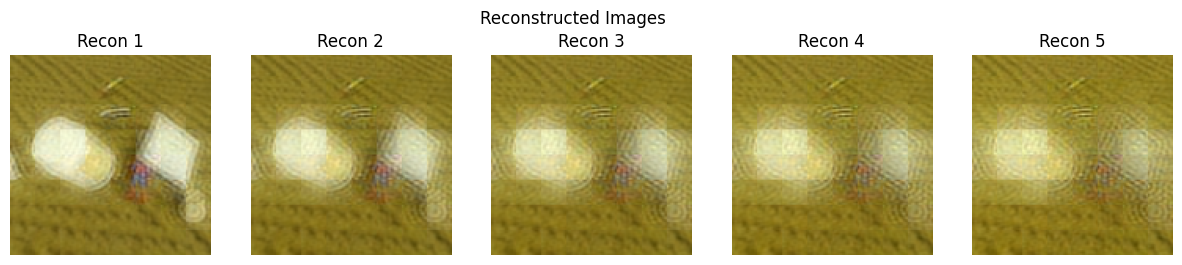

In [122]:
plot_predictor_images(input_images, target_images, recons)

## ***2. Object-Centric Scene Representation***

 *  **Object-Centric Transformer-AutoEncoder Module**

In [18]:
from model.oc_encoder import ObjectCentricEncoder
from model.oc_decoder import ObjectCentricDecoder

In [19]:
oc_encoder = ObjectCentricEncoder()
oc_decoder = ObjectCentricDecoder()

model = TransformerAutoEncoder(oc_encoder, oc_decoder)

# summary(model, input_size= rgbs.shape)


In [31]:
import torch.nn as nn

class TestCNNDecoder(nn.Module):
    def __init__(self, decoder_embed_dim=384, out_chans=3):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(decoder_embed_dim, 8 * 8 * 256),  # 384 → 8x8x256
            nn.Unflatten(1, (256, 8, 8)),  # [B, 256, 8, 8]

            nn.Upsample(scale_factor=2, mode="nearest"),  # 8x8 → 16x16
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode="nearest"),  # 16x16 → 32x32
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode="nearest"),  # 32x32 → 64x64
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode="nearest"),  # 64x64 → 128x128
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Conv2d(16, out_chans, kernel_size=3, stride=1, padding=1),  # 128x128x16 → 128x128x3
            nn.Tanh()  # Output in [-1, 1] range
        )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
test_cnn = TestCNN()
num_params = sum(p.numel() for p in test_cnn.parameters())
print(f"TestCNN has {num_params} parameters")


TestCNN has 301888 parameters


In [32]:
test_cnn = TestCNNDecoder()
num_params = sum(p.numel() for p in test_cnn.parameters())
print(f"TestCNN has {num_params} parameters")


TestCNN has 6700675 parameters


In [ ]:
vec = torch.randn(32,24,11,384)

x_flat = vec.view(32*24*11, 384)
features = test_cnn(x_flat)
features.shape


In [21]:
count_model_params(oc_encoder)

715763200

In [22]:
count_model_params(oc_decoder)

85113728

In [20]:
count_model_params(model)

800876928

In [ ]:
encoded_features = oc_encoder(rgbs, masks, coords)
print(encoded_features.shape)
recons, loss = oc_decoder(encoded_features, rgbs)
print(recons.shape)


 *  **Object-Centric Transformer-Predictor Module**

In [22]:
from model.oc_predictor import ObjectCentricTransformerPredictor

oc_predictor = ObjectCentricTransformerPredictor()
predictor = PredictorWrapper(oc_predictor)
model = TransformerPredictor(oc_encoder, oc_decoder, predictor)

summary(model, input_size= rgbs.shape)


NameError: name 'PredictorWrapper' is not defined

In [ ]:
<p align="center">
  <figure style="display:inline-block; margin: 10px; text-align: center;">
    <img src="experiments/images/recons-M.gif" alt="Image 1" width="750px" height="450px">
    <figcaption><b>Figure 1:</b> Reconstruction - Model M</figcaption>
  </figure>

  <figure style="display:inline-block; margin: 10px; text-align: center;">
    <img src="experiments/images/recons-XL.gif" alt="Image 2" width="750px" height="450px">
    <figcaption><b>Figure 2:</b> Reconstruction - Model XL</figcaption>
  </figure>
</p>
